# Translation with Seq2Seq Transformers 

first import everything

In [45]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, pipeline
import numpy as np


In [4]:
data = load_dataset('kde4', lang1='en', lang2='fr')
data

Generating train split: 100%|██████████| 210173/210173 [00:01<00:00, 106576.88 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

The dataset is huge, we make it smaller by sampling 1000 rows

In [19]:
small = data["train"].shuffle(seed=42).select(range(1_000))
split = small.train_test_split(seed=42, test_size=0.2)
split["train"][0]

{'id': '38288', 'translation': {'en': 'M', 'fr': 'M'}}

Next we load the tokenizer for our model

In [20]:
checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [21]:
en = split['train'][5]['translation']['en']
fr = split['train'][5]['translation']['fr']
en, fr

("Cannot handle drop events of type '%1 '.", 'Calendrier actif')

Tokenize the starting language

In [22]:
inputs = tokenizer(en)
inputs

{'input_ids': [1989, 5310, 9176, 8428, 1912, 7, 542, 25, 3878, 548, 25, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

tokenize the target language

In [23]:
targets = tokenizer(text_target=fr)
targets

{'input_ids': [17923, 7175, 0], 'attention_mask': [1, 1, 1]}

In [24]:
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Calendrier', '▁actif', '</s>']

if we don't use the correct tokenizer for the correct language, the tokens are wrong

In [25]:
# wrong language
bad_targets = tokenizer(fr)
tokenizer.convert_ids_to_tokens(bad_targets['input_ids'])

['▁Cal', 'end', 'rier', '▁act', 'if', '</s>']

Let's plot the size of the starting language sentences

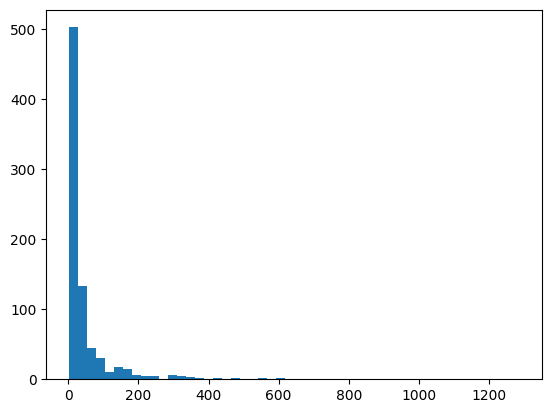

In [26]:
train = split['train']['translation']
input_lens = [len(tr['en']) for tr in train]

plt.hist(input_lens, bins=50);

Same for target language:

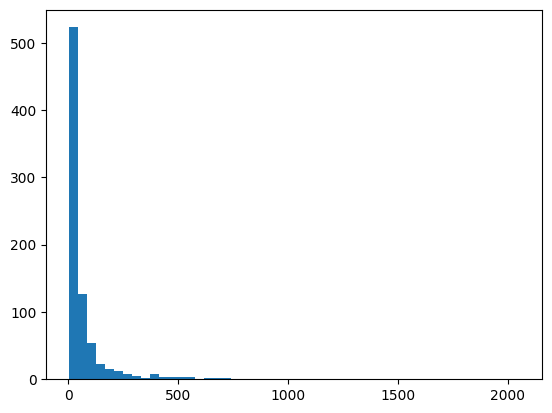

In [27]:
target_lens = [len(tr['fr']) for tr in train]
plt.hist(target_lens, bins=50);

Now we can build our tokenizer function with the correct max_length

In [28]:
max_input_len = 128
max_target_len = 128

def tokenizer_fn(batch):
  inputs = [x['en'] for x in batch['translation']]
  targets = [x['fr'] for x in batch['translation']]

  tokenized_inputs = tokenizer(
    inputs, max_length=max_input_len, truncation=True)

  tokenized_targets = tokenizer(
    text_target=targets, max_length=max_target_len, truncation=True)
  # huggingface api expects the target to be under the 'labels' column
  tokenized_inputs['labels'] = tokenized_targets['input_ids']
  return tokenized_inputs

In [29]:
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True,
    remove_columns=split['train'].column_names,
)
tokenized_datasets

Map: 100%|██████████| 200/200 [00:00<00:00, 13526.30 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
})

### Create Model

In [31]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

pytorch_model.bin: 100%|██████████| 301M/301M [00:46<00:00, 6.43MB/s] 
(…)n-fr/resolve/main/generation_config.json: 100%|██████████| 293/293 [00:00<00:00, 1.02MB/s]


Next we create our data collator: it will create the decoder inputs for our seq2seq decoder. It basically shift the target inputs by 1 in the sequence.

In [33]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [34]:
[tokenized_datasets["train"][i] for i in range(1, 3)]

[{'input_ids': [16627, 28079, 0],
  'attention_mask': [1, 1, 1],
  'labels': [17308, 33250, 0]},
 {'input_ids': [741, 0], 'attention_mask': [1, 1], 'labels': [683, 0]}]

In [35]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
print('keys: ', batch.keys())
print('labels: ', batch['labels'])
# think of seq2seq RNNs - the decoder RNN must have "some" input
# it's just like a language model where we predict the next word from
# previous words!
print('decoder inputs ids: ', batch["decoder_input_ids"])


keys:  dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])
labels:  tensor([[17308, 33250,     0],
        [  683,     0,  -100]])
decoder inputs ids:  tensor([[59513, 17308, 33250],
        [59513,   683,     0]])


In [36]:
# the first token is a pad!
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>', '▁Gé', 'ométrie']

In [37]:
# the labels are one step ahead - just like a language model
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁Gé', 'ométrie', '</s>']

### Metrics

In [40]:
bleu_metric = load_metric('sacrebleu')
bert_metric = load_metric('bertscore')

In [43]:
pred = 'I love it when cats are curled up in a ball of fur.'
ref = 'I like when cats are curled up in a furry ball.'
# blue metric matches word by word
bleu = bleu_metric.compute(predictions=[pred], references=[[ref]])
# bert metric uses a bert model to compute sentence embedding and compares the prediction and references meaning
bert = bert_metric.compute(predictions=[pred], references=[[ref]], lang='en')

print('Bleu Metric: ', bleu)
print('BERT Metric: ', bert)

Bleu Metric:  {'score': 47.27526606311562, 'counts': [10, 6, 5, 4], 'totals': [14, 13, 12, 11], 'precisions': [71.42857142857143, 46.15384615384615, 41.666666666666664, 36.36363636363637], 'bp': 1.0, 'sys_len': 14, 'ref_len': 12}
BERT Metric:  {'precision': [0.9654814600944519], 'recall': [0.9786436557769775], 'f1': [0.9720179438591003], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.32.1)'}


In [44]:
def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
  preds, labels = preds_and_labels

  # convert predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  # for any -100 label, replace with pad token id
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  # convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # get rid of extraneous whitespace
  # and also, put targets into lists
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions=decoded_preds, references=decoded_labels)
  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='fr')

  return {"bleu": bleu["score"], 'bert_score': np.mean(bert_score['f1'])}

### Train and evaluate our model

In [50]:
training_args = Seq2SeqTrainingArguments(
  output_dir="finetuned-translation-model",
  evaluation_strategy="no",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=3,
  predict_with_generate=True,
  # fp16=True, # not working on M2 macs
)

In [51]:
trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Let's evaluate the model once before the training

In [53]:
# let's check our metrics before we start!
trainer.evaluate(max_length=max_target_len)

model.safetensors: 100%|██████████| 714M/714M [01:24<00:00, 8.42MB/s]
8it [05:34, 41.77s/it]


{'eval_loss': 1.7369401454925537,
 'eval_bleu': 37.07751593966497,
 'eval_bert_score': 0.8569478665292263,
 'eval_runtime': 187.2348,
 'eval_samples_per_second': 1.068,
 'eval_steps_per_second': 0.021}

In [54]:
trainer.train()

100%|██████████| 75/75 [02:50<00:00,  2.27s/it]

{'train_runtime': 170.5714, 'train_samples_per_second': 14.07, 'train_steps_per_second': 0.44, 'train_loss': 1.6109947713216146, 'epoch': 3.0}


TrainOutput(global_step=75, training_loss=1.6109947713216146, metrics={'train_runtime': 170.5714, 'train_samples_per_second': 14.07, 'train_steps_per_second': 0.44, 'train_loss': 1.6109947713216146, 'epoch': 3.0})

In [55]:
# check the metric again after training
trainer.evaluate(max_length=max_target_len)

100%|██████████| 4/4 [00:28<00:00,  7.10s/it]


{'eval_loss': 1.594087839126587,
 'eval_bleu': 41.08893804440268,
 'eval_bert_score': 0.873041210770607,
 'eval_runtime': 47.2282,
 'eval_samples_per_second': 4.235,
 'eval_steps_per_second': 0.085,
 'epoch': 3.0}

### Save model and test it

In [56]:
trainer.save_model('english_2_french_translator')

In [57]:
translator = pipeline('translation', model='english_2_french_translator', device='mps')

In [61]:
translator('I would like to try this on a more powerful computer.')[0]['translation_text']

"J'aimerais essayer ça sur un ordinateur plus puissant."